<!--
# SQLITE Database
To explore the SQLITE database, you can download (https://sqlitebrowser.org/).  There is a portable executable.
-->

# What's in a mean? <i>or</i> A Visual Primer On Linear Regression  
**David S. Fulford**  
*December, 2018*

[Linear regression](https://en.wikipedia.org/wiki/Linear_regression "Wikipedia") is the simplest case of machine learning, and the most important, because most people apply the concept *every day*. Whenever someone computes an arithmetic mean, we have the application of a special case of linear regression &mdash; that is, that the best predictor of a response variable is the bias (or mean) of the response itself.

While there are many resources to learn about linear regression, much of them take a formal approach and are dense with statistical jargon. My intent is to avoid as much of that as possible, and use some of the tools we have available to *show* the use of linear regression to explore &amp; explain a data set. There will be some math involved that I feel is necessary to gain a solid understanding of how the regression algorithms operate, but we'll avoid F-statists, p-values, and the like.

[Khan Academy](https://www.khanacademy.org/math/statistics-probability/describing-relationships-quantitative-data "Exploring bivariate numerical data") has a thorough introduction to bivariate data analysis (simple linear regression). I feel the pace of this is a bit slow, and makes the math harder than it really is by completely avoiding linear algebra. Because we are dealing with arrays and matrices in our data structures, linear algebra is actually a really important subject to be familiar with as it often simplies what might be a complex `for` or `do` loop into a much simpler functional operation. So, I'll provide some basic linear algebra, nothing too complex, to introduce the important concepts.

#### Import the libraries we'll be using
* [Numpy](http://www.numpy.org/) is one of the fundamental packages for Python that provides access to powerful functions for working with arrays.
* [Matplotlib](https://matplotlib.org/) is a simple and powerful library for plotting.
* [Pandas](https://pandas.pydata.org/) is a library to replicates the R dataframe construct for Python. It isn't necessary, but it does help maintain the relations of our variables and provide a useful data collation object so we are not constantly passing multiple arrays around.
* [Scipy](https://www.scipy.org/) is extends the utility of Numpy with more complex and rigorous implementations of scientific functions. It re-implements the entirety of Numpy, meaning scipy.exp() is the same as Numpy.exp(), etc. It also provides a lot of extension to the core Numpy libraries. For any math, it is recommend to use the Scipy implementation instead of the Numpy one.
* [Scikit-learn](https://scikit-learn.org) is a machine learning library. It contains a great deal of functionality to simplify data analysis. We make use of it to generate some example data for a regression.

We'll also setup a seaborn style (white) for our plots, and store the color palette to an object for easy reference. Last, we setup the use of magics with matplotlib. Magics are the lines that begin with `%`, which are commands interpreted by the IPython shell rather than the Python kernel. We'll use this to create fixed plot output for printing rather than interactive plots!

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d as plt3d
import pandas as pd
import scipy as sc
import sklearn as sk

from sklearn import datasets

#Do not display warnings
import warnings
warnings.simplefilter('default')

#Inline magic and style
%matplotlib inline
plt.style.use('seaborn-white')
colors = [p['color'] for p in plt.rcParams['axes.prop_cycle']]

## Linear Regression &ndash; the basics
The word "linear" in "linear model" does not refer to the terms of the individual predictor variables of the model such as whether they are squared, or have a square root, etc. Rather, it refers to the behavior of the model as a whole. A linear model is one in which the predictor variables are independent, and therefore a linear combination of the predictor variables yields a prediction of a response variable. This means that:

$$
y = m_1 x_1 + m_2 x_2 + b
$$

is a linear model, where $x_1$ could be:  

$$
x_1 =\text{measurement},\; 
\textit{or }x_1=  {\text{measurement}}^2, \;
\textit{or even } x_1 = \frac{1}{(\text{measurement} \; - \; 10,000)^{\frac{1}{3}}}
$$

These example transformations of the predictor variable $x_1$ are most certainly *non-linear*, but the model itself is a *linear combination* of the transformed variable and maybe other transformed variables.

More generally, we write this using vector notation:  

$$
\vec{y} = m_1 \vec{x_1} + m_2 \vec{x_2} + b
\;\;\; \textit{or} \;\;\;
Y = m_1 X_1 + m_2 X_2 + b \: X_0 \;\;\; \text{where $X_0$ is a unit column vector.}
$$

If we want to keep going (we do), it's pretty inconvenient to keep writing $ m_1 X_1 + m_2 X_2 + b $ all the time. So, we will write this using matrix notation, where $x_{ij}$ is the $i^{th}$ value of vector $X_j$... i.e. row $i$ and column $j$ of the matrix with $n$ total rows and $m$ total columns.  

$$
X_0 = \begin{bmatrix} 1 \\ 1 \\ 1 \\ \vdots \\ 1 \end{bmatrix}
\;\;\;
X_1 = \begin{bmatrix} x_{11} \\ x_{21} \\ x_{31} \\ \vdots \\ x_{n1} \end{bmatrix}
\;\;\;
X_2 = \begin{bmatrix} x_{12} \\ x_{22} \\ x_{32} \\ \vdots \\ x_{n2} \end{bmatrix}
$$

And combining into a matrix:  

$$
X = \begin{bmatrix}
   1 & x_{11}  & x_{12}  & x_{13}  & \dots  & x_{1m}  \\
   1 & x_{21}  & x_{22}  & x_{23}  & \dots  & x_{2m}  \\
   1 & x_{31}  & x_{32}  & x_{33}  & \dots  & x_{3m}  \\
   1 & \vdots & \vdots & \vdots & \ddots & \vdots \\
   1 & x_{n1}  & x_{n2}  & x_{n3}  & \dots  & x_{nm}  \\
\end{bmatrix}
$$

We also have the same for our array of coefficients:  

$$
\begin{bmatrix} \beta_1 \\ \beta_2 \\ \vdots \\ \beta_m \end{bmatrix}
$$

Substituing these into our original regression equation, we get:  

$$
E[Y|X] = X\beta
\;\;\; \textit{or} \;\;\;
Y = X\beta + e
$$

where $E[\theta]$ is the expected value operator:  

$$
E[\theta] = \frac{1}{n} \sum\limits_{i=1}^n \theta_i
$$

Where $e$ is the error between the actual value, $Y$, and the mean value (or expected value), $E[Y|X]$. When we perform a regression, we do not know the true model. Therefore, the model we build through regression uses *estimates* of the true parameters. This model is:  

$$
\hat{Y} = X\hat{\beta} \\
Y = \hat{Y} + \hat{e} \\
Y = X\hat{\beta} + \hat{e}
$$

And the equivalent matrix notation, known as the [design matrix](https://en.wikipedia.org/wiki/Design_matrix "Wikipedia"):  

$$
\begin{bmatrix} y_1 \\ y_2 \\ y_3 \\ \vdots \\ y_n \end{bmatrix}
\; = \;
\begin{bmatrix}
   1 & x_{11}  & x_{12}  & x_{13}  & \dots  & x_{1m}  \\
   1 & x_{21}  & x_{22}  & x_{23}  & \dots  & x_{2m}  \\
   1 & x_{31}  & x_{32}  & x_{33}  & \dots  & x_{3m}  \\
   1 & \vdots & \vdots & \vdots & \ddots & \vdots \\
   1 & x_{n1}  & x_{n2}  & x_{n3}  & \dots  & x_{nm}  \\
\end{bmatrix}
\;
\begin{bmatrix} \beta _1 & \beta _2 & \dots & \beta _m \end{bmatrix} '
\; + \;
\begin{bmatrix} e_1 \\ e_2 \\ e_3 \\ \vdots \\ e_n \end{bmatrix}
$$

## Solving the Regresion Equation
"To solve" the regression equation means to find the values of $\beta$ that minimize the values of $e$. Because no one wants to do calculus with their linear algebra, we'll use the algebraic form of the regression equation to derive the solution, and then transform into the linear algebra equivalent.

Without getting into the details (yet), the estimator that, when minimizes, returns the arithmetic mean or expected value, is given by:  

$$
\text{argmin} \; J(\beta_0, \beta_1) = \sum\limits_{i=1}^n \left( y_i - \left[ \beta_0 + \beta_1 x_i \right] \right)^2 
$$

Where $J(\beta_0,\beta_1)$ represents our cost function we wish to minimize. If our cost function is smooth and differentiable, then $ \frac{\partial J}{\partial \beta_0}=\frac{\partial J}{\partial \beta_1}=0 $ at argmin $J(\beta_0,\beta_1)$. Taking our partial derivatives and setting equal to zero:  

$$
\large{
\begin{cases}
\frac{\partial J(\beta_0,\beta_1)}{\partial \beta_0} & = -\sum 2 \left( y_i - \beta_o - \beta_1 x_i \right) = 0 \\[1.5ex]
\frac{\partial J(\beta_0,\beta_1)}{\partial \beta_1} & = -\sum 2 \left( y_i - \beta_o - \beta_1 x_i \right) x_i = 0
\end{cases}
}
$$

And then solving the first equation (noting that the hat, $\hat{}$, is an *estimator* of the true parameter):  

$$
\begin{align}
\sum \left( y_i - \hat\beta_0 - \hat\beta_1 x_i \right) & = 0 \\[1.5ex]
\sum y_i - \sum \hat\beta_0 - \sum \hat\beta_1 x_i & = 0 \\[1.5ex]
\sum y_i - n \hat\beta_0 - \hat\beta_1 \sum x_i & = 0 \\[1.5ex]
n \hat\beta_0 & = \sum y_i - \hat\beta_1 \sum x_i \\[1.5ex]
\hat\beta_0 & = \frac{1}{n}\sum y_i - \hat\beta_1 \frac{1}{n} \sum x_i \\[1.5ex]
\text{Noting that:} \; & \frac{1}{n}\sum\limits_{i=1}^n x = \bar{x} \\[1.5ex]
\\
\hat\beta_0 & = \bar y_i - \hat\beta_1 \bar x_i
\end{align}
$$  

Indicating the regresion line must fit through the point $(\bar x, \bar y)$.

<br>
Solving the second equation:  

$$
\begin{align}
-\sum 2(y_i - \hat\beta_0 - \hat\beta_1 x_i)x_i = 0 \\[1.5ex]
\sum y_i x_i - \hat\beta_0 \sum x_i - \hat\beta_1 \sum x_i^2 = 0 \\[1.5ex]
\end{align}
$$

Substituting our first solution for $\beta_0$: 
 
$$
\begin{align}
\sum y_i x_i - \left[ \bar y_i - \hat\beta_1 \bar x_i \right] \sum x_i - \hat\beta_1 \sum x_i^2 & = 0 \\[1.5ex]
\sum y_i x_i - \left[ \frac{1}{n} \sum y_i - \hat\beta_1 \frac{1}{n} \sum x_i \right] \sum x_i - \hat\beta_1 \sum x_i^2 & = 0 \\[1.5ex]
\sum y_i x_i - \frac{1}{n} \sum y_i \sum x_i  + \hat\beta_1 \frac{1}{n}\left(\sum x_i \right)^2 - \hat\beta_1 \sum x_i^2 & = 0 \\[1.5ex]
\end{align}
$$  
$$
\hat\beta_1 \left( \sum x_i^2 - \frac{1}{n} \left( \sum x_i \right)^2 \right) = \sum y_i x_i - \frac{1}{n} \sum y_i \sum x_i
$$

We need to prove an identity to proceed. Starting with the RHS:  

$$
\begin{align}
\text{RHS} & = \sum ( y_i - \bar y )( x_i - \bar x ) = SXY \\[1.5ex]
\text{RHS} & = \sum \bigl[ y_i x_i - y_i \bar x - x_i \bar y + \bar y \bar x \bigr] \\[1.5ex]
\text{RHS} & = \sum y_i x_i - \sum y_i \bar x - \sum x_i \bar y + \sum \bar y \bar x \\[1.5ex]
\text{RHS} & = \sum y_i x_i - \bar x \sum y_i - \bar y \sum x_i + \sum \bar y \bar x \\[1.5ex]
\text{RHS} & = \sum y_i x_i - \frac{1}{n} \sum x_i \sum y_i - \frac{1}{n} \sum y_i \sum x_i + n \bar y \bar x \\[1.5ex]
\text{RHS} & = \sum y_i x_i - \frac{1}{n} \sum x_i \sum y_i - \frac{1}{n} \sum y_i \sum x_i + n \frac{1}{n} \sum y_i \frac{1}{n} \sum  x_i \\[1.5ex]
\text{RHS} & = \sum y_i x_i - \frac{1}{n} \sum x_i \sum y_i
\end{align}
$$

Similarly, the LHS is:  

$$
\text{LHS} = \hat\beta_1 \sum ( x_i - \bar x )^2 = SXX
$$

Combining the LHS and RHS, we have:  

$$
\begin{align}
\text{LHS} & = \hat\beta_1 \sum ( x_i - \bar x )^2 = \sum ( y_i - \bar y )( x_i - \bar x ) = \text{RHS} \\[1.5ex]
\hat\beta_1 & = \frac {\sum ( y_i - \bar y )( x_i - \bar x )} {\sum ( x_i - \bar x )^2} = \frac {SXY} {SXX}
\end{align}
$$

The LHS and RHS  terms are represented more generally by the linear algebra given below. The matrix shown is for a bivariate regression, e.g. one predictor variable and the first column is $X$ is a unit column.  
 
$$
\begin{align}
\sum ( x_i - \bar x )^2 & = X'X = \begin{bmatrix} n & \sum x_i \\ \sum x_i & \sum x_i^2 \end{bmatrix} \\[1.5ex]
\sum ( y_i - \bar y )( x_i - \bar x ) & = X'Y = \begin{bmatrix} \sum y_i \\ \sum y_i x_i \end{bmatrix}
\end{align}
$$

Which gives the solution for $\beta$ as:  
 
$$
\begin{align}
\beta & = (X'X)^{-1}X'Y
\end{align}
$$

When $X$ is a *unit* column vector, we return the mean of $Y$.  

$$
\begin{align}
X'X & =  n \\[1.5ex]
X'Y & = \sum y_i \\[1.5ex]
\end{align}
$$  
$$
\beta = \frac{1}{n}\sum y_i = \bar y
$$

So, we have the arithmetic mean of a variable as the minimization of the squares of that variable and a unit column vector. Importantly, this suggests that the required assumptions for least squares regression ***also*** apply to the calculation of averages. These are:  
* The residuals have a Gaussian distribution with $\mu = 0$
* The residuals have constant $\sigma^2$ across all predicted values (known as homoscedasticity)
* The residuals are i.i.d. (independent and identically distributioned). There can be no correlation, or autocorrelation such as one often finds in time series data

Least squares regression is also prone to giving too much weighting to outliers and leverage points (those points $(x_i, y_i)$ that are far from $\bar x$ or $\bar y$, respectively). This is a consequence of that fact that residuals are squared. Other, more robust cost functions that do not square errors exist, and are often used, but do not have an analytic solution to find the best-fit coefficients of the regression equation. Traditionally, one had to implement numeric algorithms, either built or bought.

Since we are discussing analytics and machine learning, a little bit later in this notebook we'll investigate what some of these other cost functions are, and how simple it is to use them!

## Geometric Representation
We may also image the least squares regression problem geometrically. This is helpful to visualize the relationship of the estimator of the response variable, $\hat{y}$, with the true value of the response variable, $y$. We'll draw two predictor variables, $x_1$ and $x_2$ as vectors to represent an example of a specific observation from some set of data.

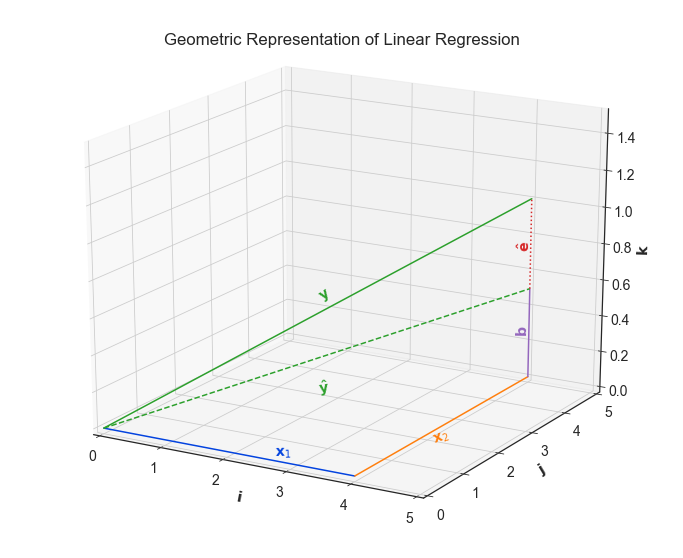

In [32]:
mpl.rcParams['font.size'] = 14
fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(111, projection='3d')

# Create X1 vector
X1_x = np.linspace(0,4,10)
X1_y = np.linspace(0,0,10)
X1_z = np.linspace(0,0,10)
X1 = [X1_x, X1_y, X1_z]

# Create X2 vector
X2_x = np.linspace(4,4,10)
X2_y = np.linspace(0,5,10)
X2_z = np.linspace(0,0,10)

# Create b vector
b_x = np.linspace(4,4,10)
b_y = np.linspace(5,5,10)
b_z = np.linspace(0,.5,10)

# Create Y vector
Y_x = np.linspace(0,4,10)
Y_y = np.linspace(0,5,10)
Y_z = np.linspace(0,1,10)

# Plot vectors
ax1.plot(X1_x, X1_y, X1_z, c=colors[0])
ax1.plot(X2_x, X2_y, X2_z, c=colors[1])
ax1.plot(Y_x, Y_y, Y_z, c=colors[2])

# Plot bias
ax1.plot(b_x, b_y, b_z, c=colors[4])

# Plot estimator
ax1.plot(Y_x, Y_y, b_z, c=colors[2], ls='--')

# Plot residual
ax1.plot(np.repeat(Y_x[-1], 10), np.repeat(Y_y[-1], 10), Y_z * .5 + .5, c=colors[3], ls=':')

# Annotate
ax1.text(X1_x[6], X1_y[0]+.15, 0, r'$\mathbf{x}_1$', zdir=(3,2,0), color=colors[0])
ax1.text(X2_x[0]+.25, X2_y[3], 0, r'$\mathbf{x}_2$', zdir=(1,3,0), color=colors[1])
ax1.text(Y_x[4], Y_y[5], Y_z[5]-.025, r'$\mathbf{y}$', zdir=(4,5,1), color=colors[2])
ax1.text(Y_x[4], Y_y[5], 0, r'$\mathbf{\hat{y}}$', zdir=(4,5,0), color=colors[2])
ax1.text(3.85, 4.85, .25, r'$\mathbf{b}$', zdir=(0,0,1), color=colors[4])
ax1.text(3.85, 4.85, .725, r'$\mathbf{\hat{e}}$', zdir=(0,0,1), color=colors[3])

# Set view
ax1.view_init(elev=20, azim=-60)
ax1.set(xlim=(0,5), ylim=(0,5), zlim=(0,1.5),
       xlabel=r'$\mathbf{i}$', ylabel=r'$\mathbf{j}$', zlabel=r'$\mathbf{k}$',
       title="Geometric Representation of Linear Regression")

plt.show()

What we see is that the residual vector, $\hat{e}$, is ***orthogonal*** to the predictors $x_1$ and $x_2$. The interpretation is that the residuals explain the variance in $y$ that is not contained in the predictor variables we have available. It is possible that additional variables exist that might explain some of the residual variance, but no amount of applied math can perform better with what is available right now. Given orthognality,  

$$
\hat{e}'X = \hat{e}'\hat{Y} = 0
$$

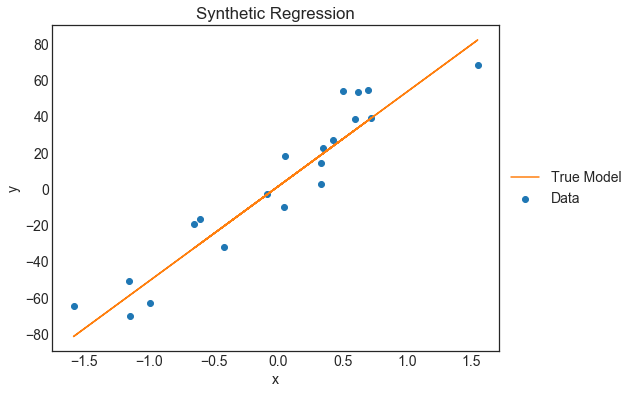

In [3]:
# Make a regression. We could do this manually, but the make_regression function gives a fixed random seed.
mr = sk.datasets.make_regression
X, Y, w = mr(n_samples=20, n_features=1, coef=True, noise=10., bias=1.5, random_state=4)

# Plot our data and true line
mpl.rcParams['font.size'] = 14
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.scatter(X, Y, c=colors[0], label='Data')
ax.plot(X, w*X + 1.5, c=colors[1], label='True Model')

plt.ylabel('y')
plt.xlabel('x')
plt.title('Synthetic Regression')
plt.legend(bbox_to_anchor=(1, .5), loc=6)

plt.show()

Next, we'll solve for the least squares solution.

In [4]:
# Setup our regression matrices
X0 = np.ones(shape=(20,2))
X0[:,1] = X.ravel()
X0 = np.asmatrix(X0)
Y0 = np.asmatrix(Y[:,None])

# Calculate the least squares solution, @ is the matrix multiplication operator
w0 = (X0.T @ X0).I @ X0.T @ Y0

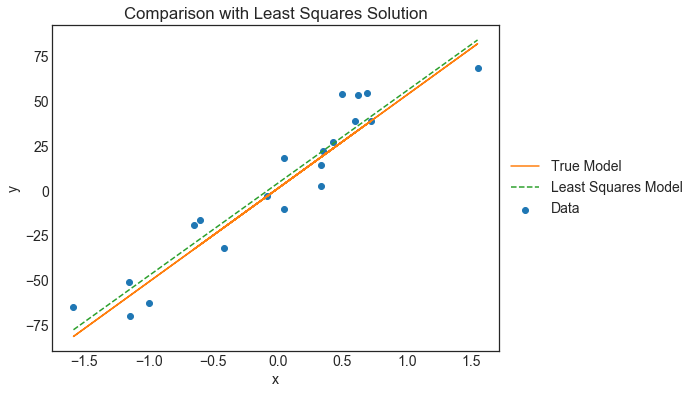

In [5]:
# Generate some test points
X_test = np.ones(shape=(20,2))
X_test[:,1] = np.linspace(min(X), max(X), 20)
Y_test = X_test @ w0

# Plot our regression
mpl.rcParams['font.size'] = 14
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.scatter(X, Y, c=colors[0], label='Data')
ax.plot(X, w*X + 1.5, c=colors[1], label='True Model')
ax.plot(X_test[:,1], Y_test, c=colors[2], ls='--', label='Least Squares Model')

plt.ylabel('y')
plt.xlabel('x')
plt.title('Comparison with Least Squares Solution')
plt.legend(bbox_to_anchor=(1, .5), loc=6)

plt.show()

Let's validate the orthogonality of our residuals. Recall that:  

$$
\begin{align}
\hat{Y} & = X\beta \\
\hat{e} & = Y - \hat{Y} \\
\hat{e}'X &  = \hat{e}'\hat{Y} = 0 \\
\hat{e}'Y & \neq 0
\end{align}
$$

First, we'll compute $\hat{e}'X$:

In [6]:
# Calculate predictions
Yhat = X0 @ w0
ehat = Y0 - Yhat
pd.DataFrame(ehat.T @ X0, columns=['Bias', r'$X$'], index=[r"$\hat{e}'X$"])

,Bias,$X$
$\hat{e}'X$,-1.776357e-14,1.516797e-13


Next we have $\hat{e}'\hat{Y}$:

In [7]:
pd.DataFrame(ehat.T @ Yhat, columns=[r"$\hat{Y}$"], index=[r"$\hat{e}'\hat{Y}$"])

,$\hat{Y}$
$\hat{e}'\hat{Y}$,7.730705e-12


And finally, $\hat{e}'Y$, which should *not* be equal to zero as the residuals contain the information orthogonal to $X$ that explains $Y$; rather, this is the residual sum of squares ($RSS$), which is used to compute the goodness of fit.

$$
RSS = \hat{e}'Y = \hat{e}'\hat{e}
$$

In [8]:
RSS1 = (ehat.T @ Y0)[0,0]
RSS2 = (ehat.T @ ehat)[0,0]
pd.DataFrame([[RSS1, '=', RSS2]], columns=['','',''], index=[r'$RSS$ ='])

,,,
$RSS$ =,3246.267061,=,3246.267061


The familiar coefficient of determination, $R^2$, follows from $RSS$ and the total sum of squares, $SS_{tot}$.

We can compute $SS_{tot}$ by:
$$
SS_{tot} = Y'Y
$$

We have the relationship that the *total* sum of squares is equal to the residual sum of squares plus the regression sum of squares ($SS_{reg}$).  

$$
SS_{reg} = \hat{Y}'Y \\[2em]
SS_{tot} = SS_{reg}+ RSS
$$

$R^2$ is then:  

$$
R^2 = 1 - \frac{RSS}{SS_{tot}} = 1 - \frac{SS_{tot}-SS_{reg}}{SS_{tot}}
$$

In [9]:
SS_tot = (Y0.T @ Y0)[0,0]
SS_reg = (Yhat.T @ Y0)[0,0]
display(pd.DataFrame([[SS_tot], [SS_reg]], columns=[''], index=[r'$SS_{tot}$ =',r'$SS_{reg}$ =']))

,
$SS_{tot}$ =,35581.801235
$SS_{reg}$ =,32335.534173


In [10]:
R2 = 1 - RSS1 / SS_tot
display(pd.DataFrame([[R2]], columns=[''], index=[r'$R^2$ =']))

,
$R^2$ =,0.908766


## Issues with Least Squares Regression
This is all well and good, but such as simple approach surely has it's issues, right?

Yes! As stated before, there are ***firm*** assumptions required for orindary least squares (OLS) to yield a quality result. Any outliers will significantly bias the result due to the *cost function* employed by least squares. Let's take a look at an example where we'll add a significant error to a single data point and observe the result.

In [11]:
# Find the the 3rd smallest X value
index = np.where(X==np.sort(X, axis=0)[2])[0]
pd.DataFrame(index, columns=[''], index=['Element #'])

,
Element #,11


In [12]:
# Add error to the the element
Y0_err = Y0.copy()
Y0_err[index] = Y0_err[index] * -1.

pd.DataFrame([[Y0[index][0,0], Y0_err[index][0,0]]], columns=['Original', 'With Error'], index=[r'$Y_{' + str(index[0]) + '}$'])

,Original,With Error
$Y_{11}$,-69.75429,69.75429


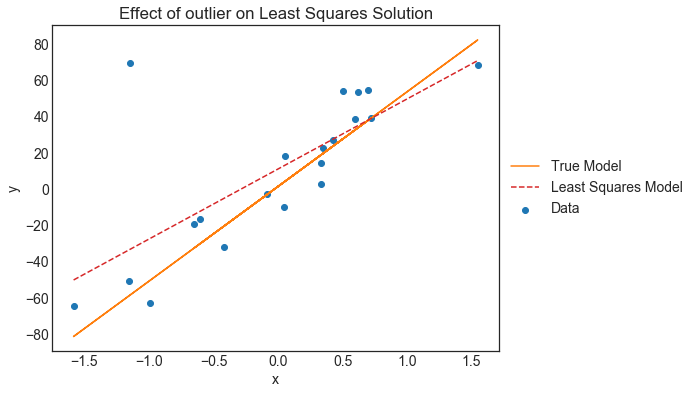

In [13]:
# Calculate the least squares solution, @ is the matrix multiplication operator
w0_err = sc.linalg.inv(X0.T @ X0) @ X0.T @ Y0_err

# Plot our regression
mpl.rcParams['font.size'] = 14
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.scatter(X0.A[:,1], Y0_err.A, c=colors[0], label='Data')
ax.plot(X, w*X + 1.5, c=colors[1], label='True Model')
ax.plot(X_test[:,1], X_test @ w0_err, c=colors[3], ls='--', label='Least Squares Model')

plt.ylabel('y')
plt.xlabel('x')
plt.title('Effect of outlier on Least Squares Solution')
plt.legend(bbox_to_anchor=(1, .5), loc=6)

plt.show()

Obviously, this is not good. To truly deal with outliers without the manual intervention of removing them from the data set, which is against the entire concept of having a computer automatically process the data for us, we'll need to investigate the use of alternative cost functions.

One diagnostic we can use to investigate the influence a data point has on the regression is to look at the [leverage of those points](https://en.wikipedia.org/wiki/Leverage_%28statistics%29). The leverage is defined as $H_{ii}$, or the diagonal of $H$ where:  

$$
H = X (X' X)^{-1} X'
$$

which is pretty easy to calculate. This is also called the **hat matrix**. Also note that:  

$$
\hat{Y} = X\hat{\beta} = X (X' X)^{-1} X' Y = HY
$$

meaning $H$ is the **projection matrix** of $Y$ onto $\hat{Y}$. Recall the geometric representation shown at the start of this notebook where $\hat{Y}$ is the projection of $Y$ and the difference of the two is the unobserved variance or residuals, $\hat{e}$.

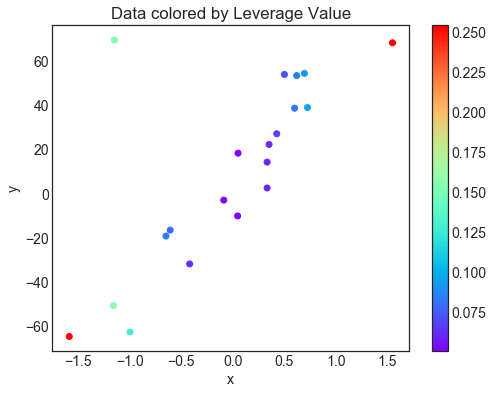

In [14]:
H = X0 @ (X0.T @ X0).I @ X0.T
H_ii = np.diag(H)

# Plot our regression
mpl.rcParams['font.size'] = 14
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax_1 = ax.scatter(X0.A[:,1], Y0_err.A, c=H_ii, cmap='rainbow', label='Data')

plt.ylabel('y')
plt.xlabel('x')
plt.title('Data colored by Leverage Value')

fig.colorbar(ax_1)

plt.show()

The utility of the leverage value is that it shows us how much the data points influence the least squares regression. Hence, we see that the data point we added error to, while not exerting the greatest amount of leverage on the regression, is significant enough that it biases our regression model.

We won't go through the derivation, but it can be shown that applying a weighting to each data point in the cost function can reduce the influence of outliers, such as:  

$$
J(\beta) = \sum\limits_{i=1}^n w_i (y_i - \beta x_i)^2
$$

The resulting solution for $\beta$ in matrix notation is then:  

$$
\hat{\beta} = (X' W X)^{-1} X' W Y
$$

This is a general result used in many types of regression, such as Weighted Least Squares (WLS), Generalized Least Squares (GLS), and Robust Regression. Each of these chooses a different method for determining the weights, and have their strengths and weaknesses. It's worth noting that WLS and GLS are used to non-constant variance in residuals or correlation in residuals, ***not*** to handle outliers. Robust Regression is good for dealing with outliers as well as the issues that WLS and GLS address, but it is also a non-parametric method.

Because we're more interesting in dealing with outliers than correlation in residuals, we'll not discuss WLS and GLS much further. Generally, outliers impact our ability to correct predict the expected value of $\hat{y}$, while correlation in the residuals has much less effect on the expected value of $\hat{y}$ but results in improper variance of $\hat{y}$. The limitation of WLS and GLS is that residuals are *still* based upon the squared differences. To be robust against outliers, we have to change the way we measure the deviance beween $y$ and $\hat{y}$.

## Alternative Norms
Least squares regression uses $(Y - X\beta)^2$ as a cost function. We can think of a cost function as a measurement of some *distance* between our predicted value and the true value. Then, the greater the distance, the poorer the model's predictions. In this framework, least squares regression is like the Euclidian distance, or straight-line distance, between two points. Generally speaking, a norm is a function that assigns a strictly positive value to a vector. The Euclidian distance is the magnitude of a vector, or the sum of the squares of the vector components. Hence, the least squares cost function is a [norm](https://en.wikipedia.org/wiki/Norm_%28mathematics%29) of L2 type where:

$$
\begin{Vmatrix} x \end{Vmatrix}_2 = \sqrt{\sum \left| x_i^2 \right|}
$$

We can have norms of any level, such as the L1 norm:  

$$
\begin{Vmatrix} x \end{Vmatrix}_1 = \sum \left| x_i \right|
$$

However, no analytic solution exists for minimizing the L1 norm. The L1 norm is also referred to as the "taxicab" norm, as it refers to the distance one must travel on a grid to get from one point to another. There are many identical length, non-unique paths between any two points. Hence, there is no analytic solution to be found.

![L1_L2_norm_distances](L1-L2-norm.png)

<center><strong>Comparison of L1 (red, yellow, blue) and L2 (green) norms, or taxicab distance and by-flight distance</strong></center>

The $p$-norm is given by:

$$
\begin{Vmatrix} x \end{Vmatrix}_p = \Bigl( {\sum \left| x_i^p \right| } \Bigr) ^{1/p}
$$

We can have an L0 norm, which would be:

$$
\begin{Vmatrix} x \end{Vmatrix}_0 = \begin{cases} 0, & \text{if $x = 0$} \\ 1, & \text{else} \end{cases}
$$

And even an L$\infty$-norm, the infinity norm or maximum norm:

$$
\begin{Vmatrix} x \end{Vmatrix}_\infty = \text{max} \left| x_i \right|
$$

Not all are norms useful for regression, but some do have features that would be great to take advantage of if we have a method to find the minimum!

## Robust Regression
The field of study associated with studying cost functions and their behaviors towards outliers and leverage points is called ***robust regression***. When the residuals are not normal, or when they are tail-heavy, one of two approaches may be taken:
1. Remove the offending data points
2. Use a regression method that is not as vulnerable to offensive data points 

2\. would be the ideal route because the sensitivity to outliers is reduced and much less effort is required to produce a robust estimate.

To highlight the issue with least squares, recall that the univariate case of least squares returns the mean. Recalling the sample mean:

$$
\begin{align}
\bar x_n & = \frac{1}{n} \sum\limits_{i=1}^n x_i \\[1.5ex]
& = \frac{1}{n} \left[ \sum\limits_{i=1}^{n-1} x_i + x_n \right] \\[1.5ex]
& = \frac{n-1}{n} \bar x_{n-1} + \frac{1}{n} x_n
\end{align}
$$

If $x_n$ is large enough, then may determine $\bar x_n$ regardless of the other $n-1$ values.

We'll take a look at the cost functions associated the L0, L1, and L2 norms, as well as one of the original *M*-estimators (Huber estimator). The Huber estimator is equal to the L2 norm at values smaller than $t$, where $t$ is some threshold of standard deviation. At values larger than $t$, the Huber estimator is linear like the L1 norm.

$$
L_H =
\begin{cases}
    \frac{1}{2}\big( y - f(x) \big)^2              &  \text{for } \lvert y - f(x) \rvert \leq t \\
    t \, \lvert y - f(x) \rvert - \frac{1}{2} t^2  &  \text{otherwise}
\end{cases}
$$

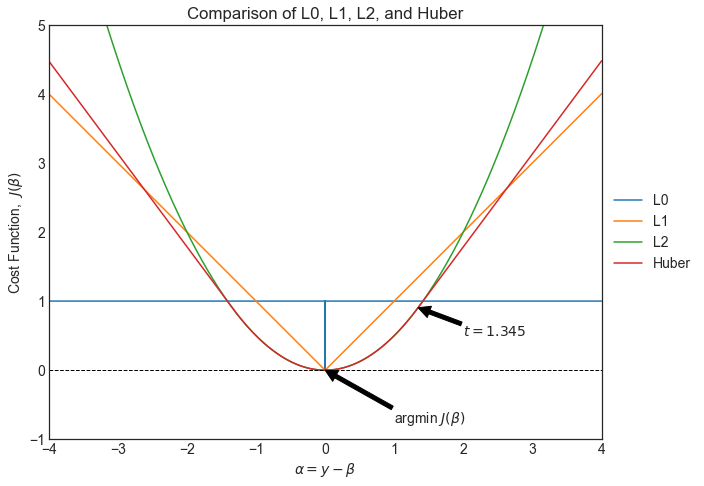

In [15]:
def huber_loss(x, t=1.345):
    # Definition from statsmodels.robust.norms.HuberT
    x = np.abs(x)
    subset = 1. * x<=1.345
    return (subset * 1/2 * x**2 + (1 - subset) * (x * t - 1/2 * t**2))

x = np.linspace(-5, 5, 10001)
l0_x = [int(i!=0) for i in x]
l1_x = np.abs(x)
l2_x = 1/2 * x**2
huber_x = huber_loss(x)

mpl.rcParams['font.size'] = 14
plt.figure(figsize=(10,8))

y = np.stack([l0_x, l1_x, l2_x, huber_x])
plt.plot(x, y.T)
plt.axhline(0, c='k', ls='--', lw=1)

plt.xlim((-4,4)); plt.ylim((-1,5))
plt.xlabel(r'$\alpha = y - \beta$')
plt.ylabel(r'Cost Function,  $J(\beta)$')
plt.title('Comparison of L0, L1, L2, and Huber')
plt.annotate(r'argmin $J(\beta)$', xy=(0, 0), xytext=(1, -.75), arrowprops=dict(facecolor='k'))
plt.annotate(r'$t = 1.345$', xy=(1.345, 1/2 * 1.345**2), xytext=(2, .5), arrowprops=dict(facecolor='k'))
labels = ['L0', 'L1', 'L2', 'Huber']
plt.legend(labels=labels, bbox_to_anchor=(1, .5), loc=6)
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()

We can see that the cost of even minor deviations from the mean can be quite costly using an L2 cost. The L1 cost is much less sensitive to outliers. The practical aspect of this is that we must be very careful to validate our data for any outliers before trusting the result from an L2 least squares regression &mdash; this includes the calculation of a mean value as well!

It is better to not have to worry so much about outliers in our data. Subsurface data especially tends to have a lot of noise and measurement error, as well as correlated errors which violate the assumptions of independence of residuals in the least squares linear model. Although with enough data the model can be robust to these outliers, in general a cost function that is more robust is preferred!

#### L2, L1, or L0 Optimization give rise to the Mean, Median and Mode
If we consider the case of L1 or L0 optimization, we might ask what values will minimize the cost function (error)? It turns out that for the L1 case, this is the ***median***, and for the L0 case, this is the ****mode***. Why is this? Let's think about how the L2 case has the ***mean*** as the value that minimizes error. The derivative of the *L2 cost function* is:  

$$
\begin{align}
\frac{d}{d\beta} J_{L2} & = \frac{d}{d\beta} \frac{1}{n} \sum\limits_{i=1}^n \left( y_i - \beta \right)^2 \\
& = -2 \frac{1}{n} \sum\limits_{i=1}^n \left( y_i - \beta \right)
\end{align}
$$

Then

$$
\beta = \bar{y}
$$

sets the L2 cost function derivative to zero. If $\bar{y} = 0$, for example, this reduces to $\frac{1}{n} \sum\limits_{i=1}^n  y_i $.

Similarly, the derivative of the *L1 cost function* is:

$$
\begin{align}
\frac{d}{d\beta} J_{L1} & = \frac{d}{d\beta} \frac{1}{n} \sum\limits_{i=1}^n \lvert y_i - \beta \rvert \\
& = \frac{1}{n} \sum\limits_{i=1}^n \begin{cases} 1 & \text{if $\beta \gt y_i$} \\ -1 & \text{if $\beta \lt y_i$} \end{cases}
\end{align}
$$

Then

$$
\beta = \text{median of} \; y
$$

Would result an an equal number of positive and negative terms, thereby setting the L1 cost function derivative to zero.

$$
\begin{align}
\frac{d}{d\beta} J_{L0} & = \frac{d}{d\beta} \frac{1}{n} \sum\limits_{i=1}^n \begin{cases} 1 & \text{if $y - \beta \neq 0$} \\ 0 & \text{otherwise} \end{cases} \\
& = 0
\end{align}
$$

Then we see that any value of $\beta$ sets the L0 cost function derivative to zero. This is true for a continuous variable, but for a discrete variable, then the condition is that $\beta$ must be equal to any of $y_i$. More generally, if values of $y_i$ are repeated, then

$$
\beta = \text{mode of} \; y
$$

Would result in the smallest number of times that the value of $y$ is not equal to the summary we use.

The Huber cost function is a combination of L2 and L1, so we can simply combine our results for the two.  

Now that we have a better understanding of how the central tendency of a variable relates to the summary statistic we use to represent that variable, and perhaps some limitations on analytic solutions to find the proper value given the equation for the derivatives, let's take a look at a numerically computed gradient to visualize the problem.

#### Cost function gradients
Recall that at the minimum of the cost function, the derivative will be zero. In the derivations, we therefore set the derivative to zero and proceeded to solve for the $ \beta $ coefficients. It turned out that for the L0 and L1, there is no continuous analytic equation to represent the derivative as a function of $\beta$. This means that no analytic method exists to uses these cost functions in a linear regression problem!

So, what if we wish to use an alternative cost function? We must walk the gradient of the cost function to zero using numerical methods. Let's take a look at the gradients of the cost functions. We'll compute them numerically to clearly illustrate the fact that L0 and L1 are not differentiable at $x=0$.

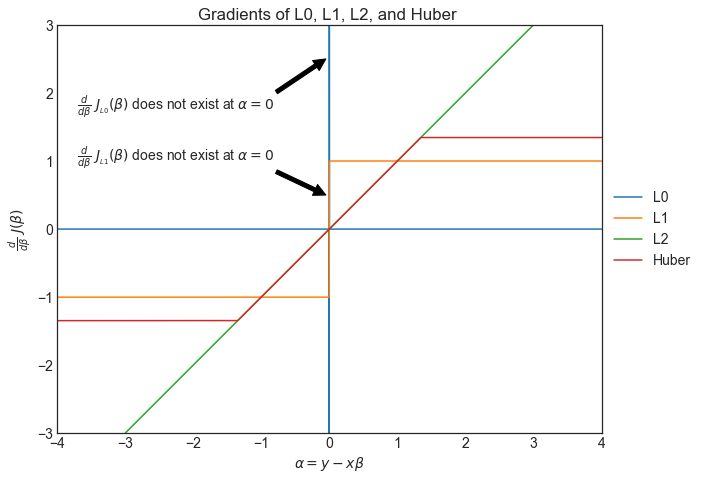

In [16]:
dy = np.asarray([np.gradient(f, x) for f in y])

mpl.rcParams['font.size'] = 14
plt.figure(figsize=(10,8))

plt.plot(x, dy.T)

plt.xlim(-4,4); plt.ylim(-3,3)
plt.xlabel(r'$\alpha = y - x\beta$')
plt.ylabel(r'$\frac {d}{d\beta}\; J(\beta) $')
plt.title('Gradients of L0, L1, L2, and Huber ')

plt.annotate(r'$ \frac{d}{d\beta} \; J_{_{L0}}(\beta) $ does not exist at $ \alpha = 0 $',
             xy=(-.05, 2.5), xytext=(-3.7, 1.75), arrowprops=dict(facecolor='k'))
plt.annotate(r'$ \frac{d}{d\beta} \; J_{_{L1}}(\beta) $ does not exist at $ \alpha = 0 $',
             xy=(-.05, .5), xytext=(-3.7, 1), arrowprops=dict(facecolor='k'))

labels = ['L0', 'L1', 'L2', 'Huber']
plt.legend(labels=labels, bbox_to_anchor=(1, .5), loc=6)
plt.gca().set_aspect('equal'); plt.tight_layout()
plt.show()

As we saw analytically, we verify numerically that the derivative does not exist at the minimum (i.e. where $y - \beta=0$) for the L0 and L1. It does exist for the L2, and Huber - but the Huber cost is not a continuous function and therefore also would require a numerical method to solve.

The method used to solve a regression problem using a *numerical approach* is, perhaps, one of the most important algorithms ever discovered &mdash; [***stochastic gradient descent***](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) (SGD). SGD is used to solve every machine learning algorithm, and recent improvements to SGD algorithms are a big contributor to the "explosion" of machine learning application's we've seen lately. Although many modern implementations may use 3$\mathrm{^{rd}}$ order and/or higher behavior to determine step direction and magnitude, the basic SGD algorithm uses 2$\mathrm{^{nd}}$ order behavior as we have derived to solve for the root of the derivative of a function (i.e. setting the derivative of a cost function to zero).

Before we get to SGD, we can visualize the cost function and gradient as a function of two parameters in 3D space. We'll first look at the L2 norm, noting that it should follow quite clearly by analogy with the 1D cost & gradient functions directly above. First, plot the cost function in 2D. We'll add a different penalty to each of the two predictor variables to give it an ellipsoid shape.

First, we'll build plotting funtions that we can simply pass the Cost and Gradient functions to. The first function, `build_mesh()`, just sets up some random data points and builds a mesh in polar coordinates.

In [17]:
def build_mesh():
    # Generate random points
    np.random.seed(1)
    x = np.random.normal(loc=0., scale=2., size=30)
    y = np.random.normal(loc=0., scale=1., size=30)

    # Build Polar Mesh
    rmesh = np.arange(0, 3, .1); 
    theta = np.linspace(0, 2 * np.pi, 360)
    rmesh, theta = np.meshgrid(rmesh, theta)
    
    return x, y, rmesh, theta

def cost_3D(cost_fun, name='', zmin=-1, zmax=3, ax=ax):
    x, y, z, xmesh, ymesh, zmesh = cost_fun()
    
    # Plot the Cost Function
    ax.scatter(x, y, z, c=z, s=50, cmap='rainbow', alpha=1, vmin=np.min(zmesh), vmax=np.max(zmesh))
    ax.plot_surface(xmesh, ymesh, zmesh, cmap='rainbow', alpha=.1, lw=.1, edgecolor='k', antialiased=True)

    # Add counter lines to the axes planes
    ax.contour(xmesh, ymesh, zmesh, zdir='z', cmap='rainbow', alpha=.5, offset=zmin)
    ax.contour(xmesh, ymesh, zmesh, zdir='x', levels=np.linspace(0,6,13), cmap='rainbow', alpha=.5, offset=-6)
    ax.scatter(x, y, -1, c=z, s=50, cmap='rainbow', alpha=1, vmin=np.min(zmesh), vmax=np.max(zmesh))

    ax.set(xlim=(-6,6), ylim=(-6,6), zlim=(zmin, zmax))
    ax.set_title(label=name + ' Cost Function', pad=20)
    ax.set_xlabel(r'$Y - X\beta_1 | \beta_2$', labelpad=10)
    ax.set_ylabel(r'$Y - X\beta_2 | \beta_1$', labelpad=10)
    ax.set_zlabel(r'Cost Function, $J(\beta)$', labelpad=15)
    ax.view_init(elev=30, azim=-60)
    
def grad_3D(grad_fun, name='', zmin=-5, zmax=3, row=(1,1)):
    x, y, zd, xmesh, ymesh, zdmesh = grad_fun()
    
    # Plot Gradient Function
    ax = fig.add_subplot(str(row[0]) + '2' + str(1+2*(row[1]-1)), projection='3d')

    ax.scatter(x, y, zd, c=zd, s=50, cmap='rainbow', alpha=1, vmin=np.min(zdmesh), vmax=np.max(zdmesh))
    ax.plot_surface(xmesh, ymesh, zdmesh, cmap='rainbow', alpha=.2, lw=.1, edgecolor='k', antialiased=True)

    # Add counter lines to the axes planes
    ax.contour(xmesh, ymesh, zdmesh, zdir='z', cmap='rainbow', alpha=.5, offset=zmin)
    ax.contour(xmesh, ymesh, zdmesh, zdir='x', cmap='rainbow', alpha=.5, offset=-6)
    #ax.contour(xmesh, ymesh, zdmesh, zdir='y', cmap='rainbow', alpha=.5, offset=6)
    ax.scatter(x, y, zmin, c=zd, s=50, cmap='rainbow', alpha=1, vmin=np.min(zdmesh), vmax=np.max(zdmesh))

    ax.set(xlim=(-6,6), ylim=(-6,6), zlim=(zmin, zmax))
    ax.set_title(label=name + ' Gradient Function', pad=20)
    ax.set_xlabel(r'$Y - X\beta_1 | \beta_2$', labelpad=15)
    ax.set_ylabel(r'$Y - X\beta_2 | \beta_1$', labelpad=15)
    ax.set_zlabel(r'$\frac {d}{d\beta}\; J(\beta) $', labelpad=15)
    ax.view_init(elev=30, azim=-60)

    # Plot 2
    ax = fig.add_subplot(str(row[0]) + '2' + str(2+2*(row[1]-1)), projection='3d')

    ax.scatter(x, y, zd, c=zd, s=50, cmap='rainbow', alpha=1, vmin=np.min(zdmesh), vmax=np.max(zdmesh))
    ax.plot_surface(xmesh, ymesh, zdmesh, cmap='rainbow', alpha=.2, lw=.1, edgecolor='k', antialiased=True)

    # Add counter lines to the axes planes
    ax.contour(xmesh, ymesh, zdmesh, zdir='z', cmap='rainbow', alpha=.5, offset=zmin)
    ax.contour(xmesh, ymesh, zdmesh, zdir='x', cmap='rainbow', alpha=.5, offset=-6)
    #ax.contour(xmesh, ymesh, zdmesh, zdir='y', cmap='rainbow', alpha=.5, offset=6)
    ax.scatter(x, y, zmin, c=zd, s=50, cmap='rainbow', alpha=1, vmin=np.min(zdmesh), vmax=np.max(zdmesh))

    ax.set(xlim=(-6,6), ylim=(-6,6), zlim=(zmin, zmax))
    ax.set_title(label=name + ' Gradient Function', pad=20)
    ax.set_xlabel(r'$Y - X\beta_1 | \beta_2$' + '\n', labelpad=15, linespacing=3)
    ax.set_ylabel(r'$Y - X\beta_2 | \beta_1$', labelpad=15)
    ax.set_zlabel(r'$\frac {d}{d\beta}\; J(\beta) $', labelpad=15)
    ax.view_init(elev=0, azim=0)

Next, define and plot the L2 Cost function!

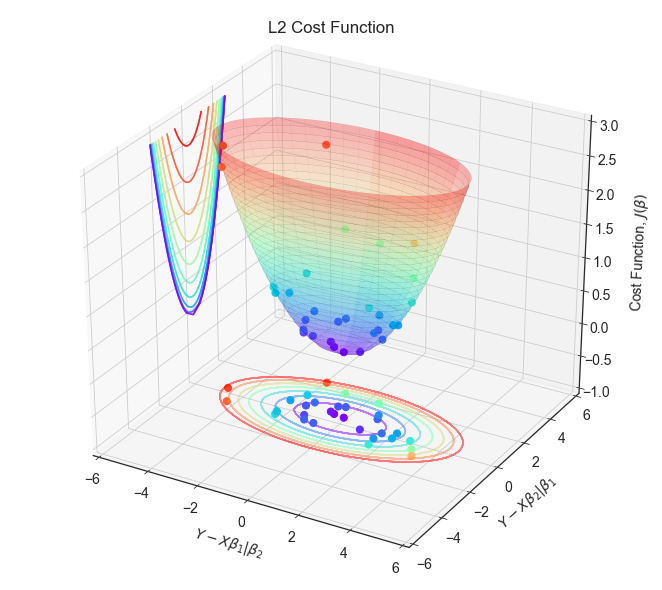

In [18]:
def L2_2D():
    # L2 Cost Function
    L2 = lambda x, s=1: 1/2 * x**2 / s**2
    L2_inv = lambda x, s=1: np.sqrt(1 / (1/2 / s**2) * x)
    zfunc = lambda x, y: L2(x, 2) + L2(y, 1)
    
    # Get mesh
    x, y, rmesh, theta = build_mesh()
    
    # Evaluate points
    z = zfunc(x, y)

    # Invert Cost to Distance & Direction for X
    xmesh = L2_inv(rmesh, 2) * np.sin(theta * np.pi)

    # Invert Cost Difference to Distance & Direction for Y
    ymesh = L2_inv(rmesh - L2(xmesh, 2), 1) * np.sign(np.cos(theta * np.pi))

    zmesh = zfunc(xmesh, ymesh)
    
    return x, y, z, xmesh, ymesh, zmesh
    
mpl.rcParams['font.size'] = 14
fig = plt.figure(figsize=(9,8))
ax = plt3d.Axes3D(fig)
cost_3D(L2_2D, 'L2', ax=ax)
plt.show()

OK, that bowl shape looks just like our 1D cost function when viewed on-edge. The counters on the bottom of the plot are iso-$J(\beta)$ lines. The counter lines on the wall are the minimum values of slices along the $Y - X\beta_1 | \beta_2$ axis.

Next we'll compute the gradient.

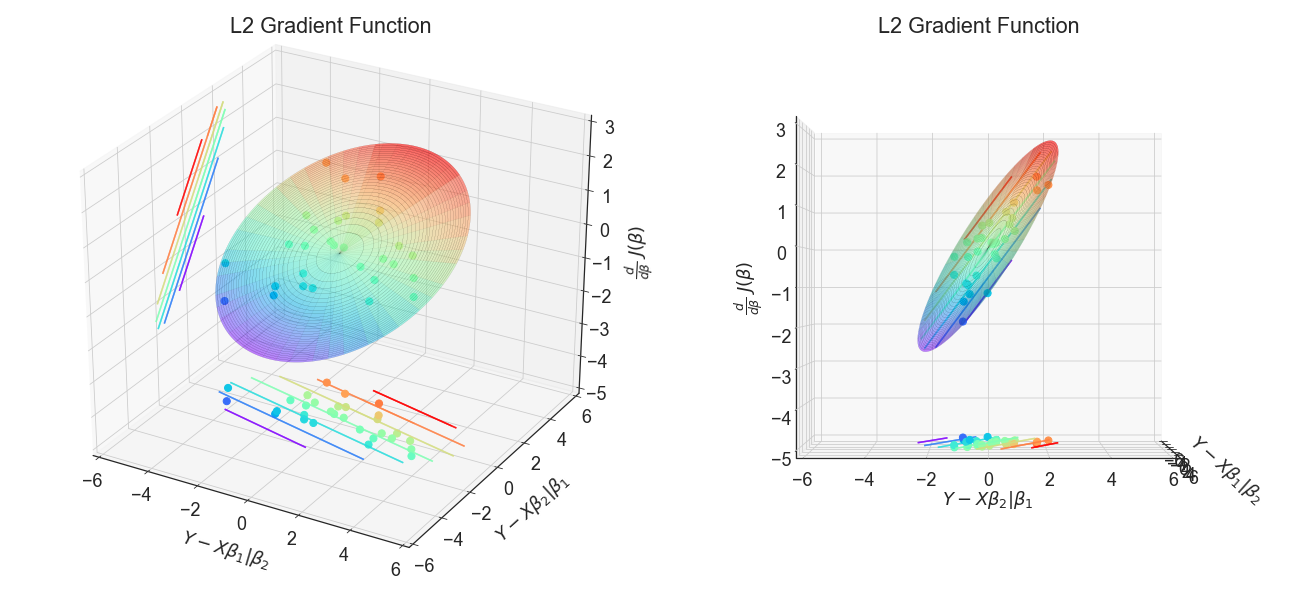

In [19]:
def L2g_2D():
    # L2 Gradient Function
    L2_g = lambda x, s=1: x / s**2
    zdfunc = lambda x, y: L2_g(x, 2) + L2_g(y, 1)

    x, y, _, xmesh, ymesh, _ = L2_2D()
    # Compute Gradient
    zd = zdfunc(x, y)
    zdmesh = zdfunc(xmesh, ymesh)
    
    return x, y, zd, xmesh, ymesh, zdmesh

mpl.rcParams['font.size'] = 18
fig = plt.figure(figsize=(18,8))
grad_3D(L2g_2D, 'L2', zmin=-5, zmax=3)
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0)
plt.show()

And once again we have a completely flat surface. If we look on-axis, we can see it dips in both directions. Hopefully it is clearly imagined what the other cost functions would look like! We'll go ahead and define the Cost and Gradient functions for L1 and Huber.

In [20]:
def L1_2D():
    # L1 Cost Function
    L1= lambda x, s=1: np.abs(x) / s
    L1_inv = lambda x, s=1: s * x
    zfunc = lambda x, y: L1(x, 2) + L1(y, 1)

    # Get mesh
    x, y, rmesh, theta = build_mesh()
    
    # Evaluate points
    z = zfunc(x, y)

    # Build Cartesian Mesh
    xmesh = L1_inv(rmesh, 2) * np.sin(theta * np.pi)
    ymesh = L1_inv(rmesh - L1(xmesh, 2), 1) * np.sign(np.cos(theta * np.pi))
    zmesh = zfunc(xmesh, ymesh)
    
    return x, y, z, xmesh, ymesh, zmesh

def L1g_2D():
    # L1 Gradient Function
    zdfunc = lambda x, y: np.sign(x) / 2 + np.sign(y)

    # Get mesh
    x, y, _, xmesh, ymesh, _ = L1_2D()
    
    # Compute Gradient
    zd = zdfunc(x, y)
    zdmesh = zdfunc(xmesh, ymesh)
    
    return x, y, zd, xmesh, ymesh, zdmesh

In [21]:
def Huber_2D():
    def huber(b, s=1, t=1.345):
        huber = np.zeros_like(b); b = np.abs(b); t = t * s
        subset = b <= t; not_subset = np.logical_not(subset)
        huber[subset] = 1/2 * b[subset]**2
        huber[not_subset] = t * b[not_subset] - 1/2 * t**2 
        return huber / s**2  

    def huber_inv(huber, s=1, t=1.345):
        x = np.zeros_like(huber); t = t * s; huber = huber * s**2
        subset = np.sqrt(np.abs(huber) * 2) <= t; not_subset = np.logical_not(subset)
        x[subset] = np.sqrt(np.abs(huber[subset]) * 2)
        x[not_subset] = (huber[not_subset] + 1/2 * t**2) / t
        return x
    
    zfunc = lambda x, y: huber(x, 2) + huber(y, 1)

    # Get mesh
    x, y, rmesh, theta = build_mesh()
    
    # Evaluate points
    z = zfunc(x, y)

    # Build Cartesian Mesh
    xmesh = huber_inv(rmesh, 2) * np.sin(theta * np.pi)
    ymesh = huber_inv(rmesh - huber(xmesh, 2), 1) * np.sign(np.cos(theta * np.pi))
    zmesh = zfunc(xmesh, ymesh)
    
    return x, y, z, xmesh, ymesh, zmesh

def Huberg_2D():
    # Huber Gradient Function
    def huber_g(b, s=1, t=1.345):
        huber = np.zeros_like(b); t = t * s;
        subset = np.abs(b) <= t; not_subset = np.logical_not(subset)
        huber[subset] = b[subset]
        huber[not_subset] = t * np.sign(b[not_subset])
        return huber / s**2

    zdfunc = lambda x, y: huber_g(x, 2) + huber_g(y, 1)
    
    # Get mesh
    x, y, _, xmesh, ymesh, _ = Huber_2D()
    
    # Compute Gradient
    zd = zdfunc(x, y)
    zdmesh = zdfunc(xmesh, ymesh)
    
    return x, y, zd, xmesh, ymesh, zdmesh

And then plot all three side-by-side to compare.

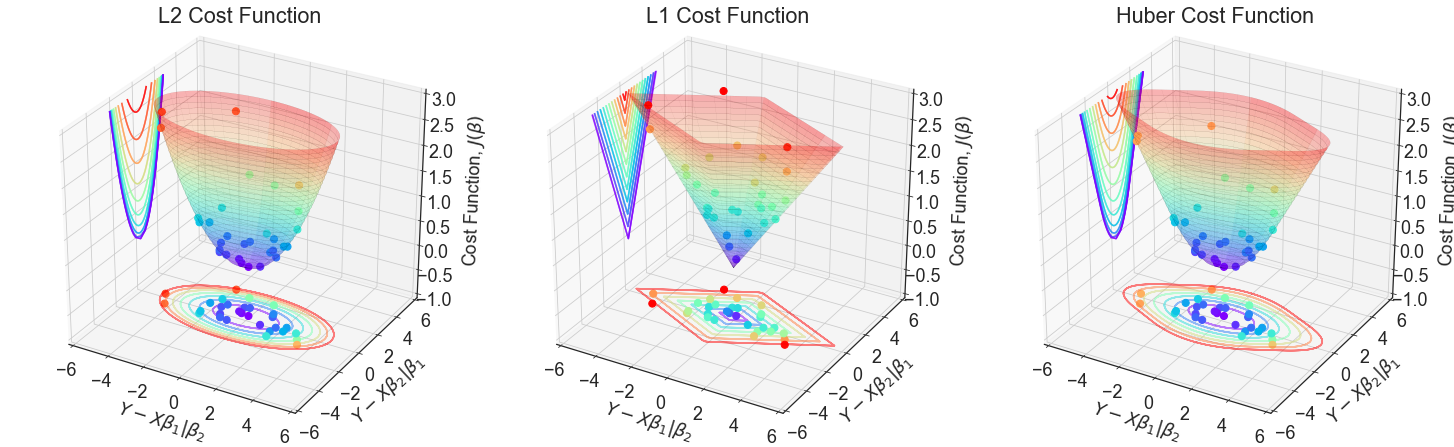

In [22]:
mpl.rcParams['font.size'] = 18
fig = plt.figure(figsize=(20,6))
# ax1 = plt3d.Axes3D(fig)
ax1 = fig.add_subplot(131, projection='3d')
cost_3D(L2_2D, 'L2', ax=ax1)

# mpl.rcParams['font.size'] = 14
# fig = plt.figure(figsize=(10,8))
# ax = plt3d.Axes3D(fig)
ax2 = fig.add_subplot(132, projection='3d')
cost_3D(L1_2D, 'L1', ax=ax2)

# mpl.rcParams['font.size'] = 14
# fig = plt.figure(figsize=(10,8))
# ax = plt3d.Axes3D(fig)
ax3 = fig.add_subplot(133, projection='3d')
cost_3D(Huber_2D, 'Huber', ax=ax3)

plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=.05, hspace=0)
plt.show()

This looks mostly as expected. The Huber combines the features of the L2 when close to 0, and the L1 when far from zero, but is also smooth which should give a nicer looking gradient.

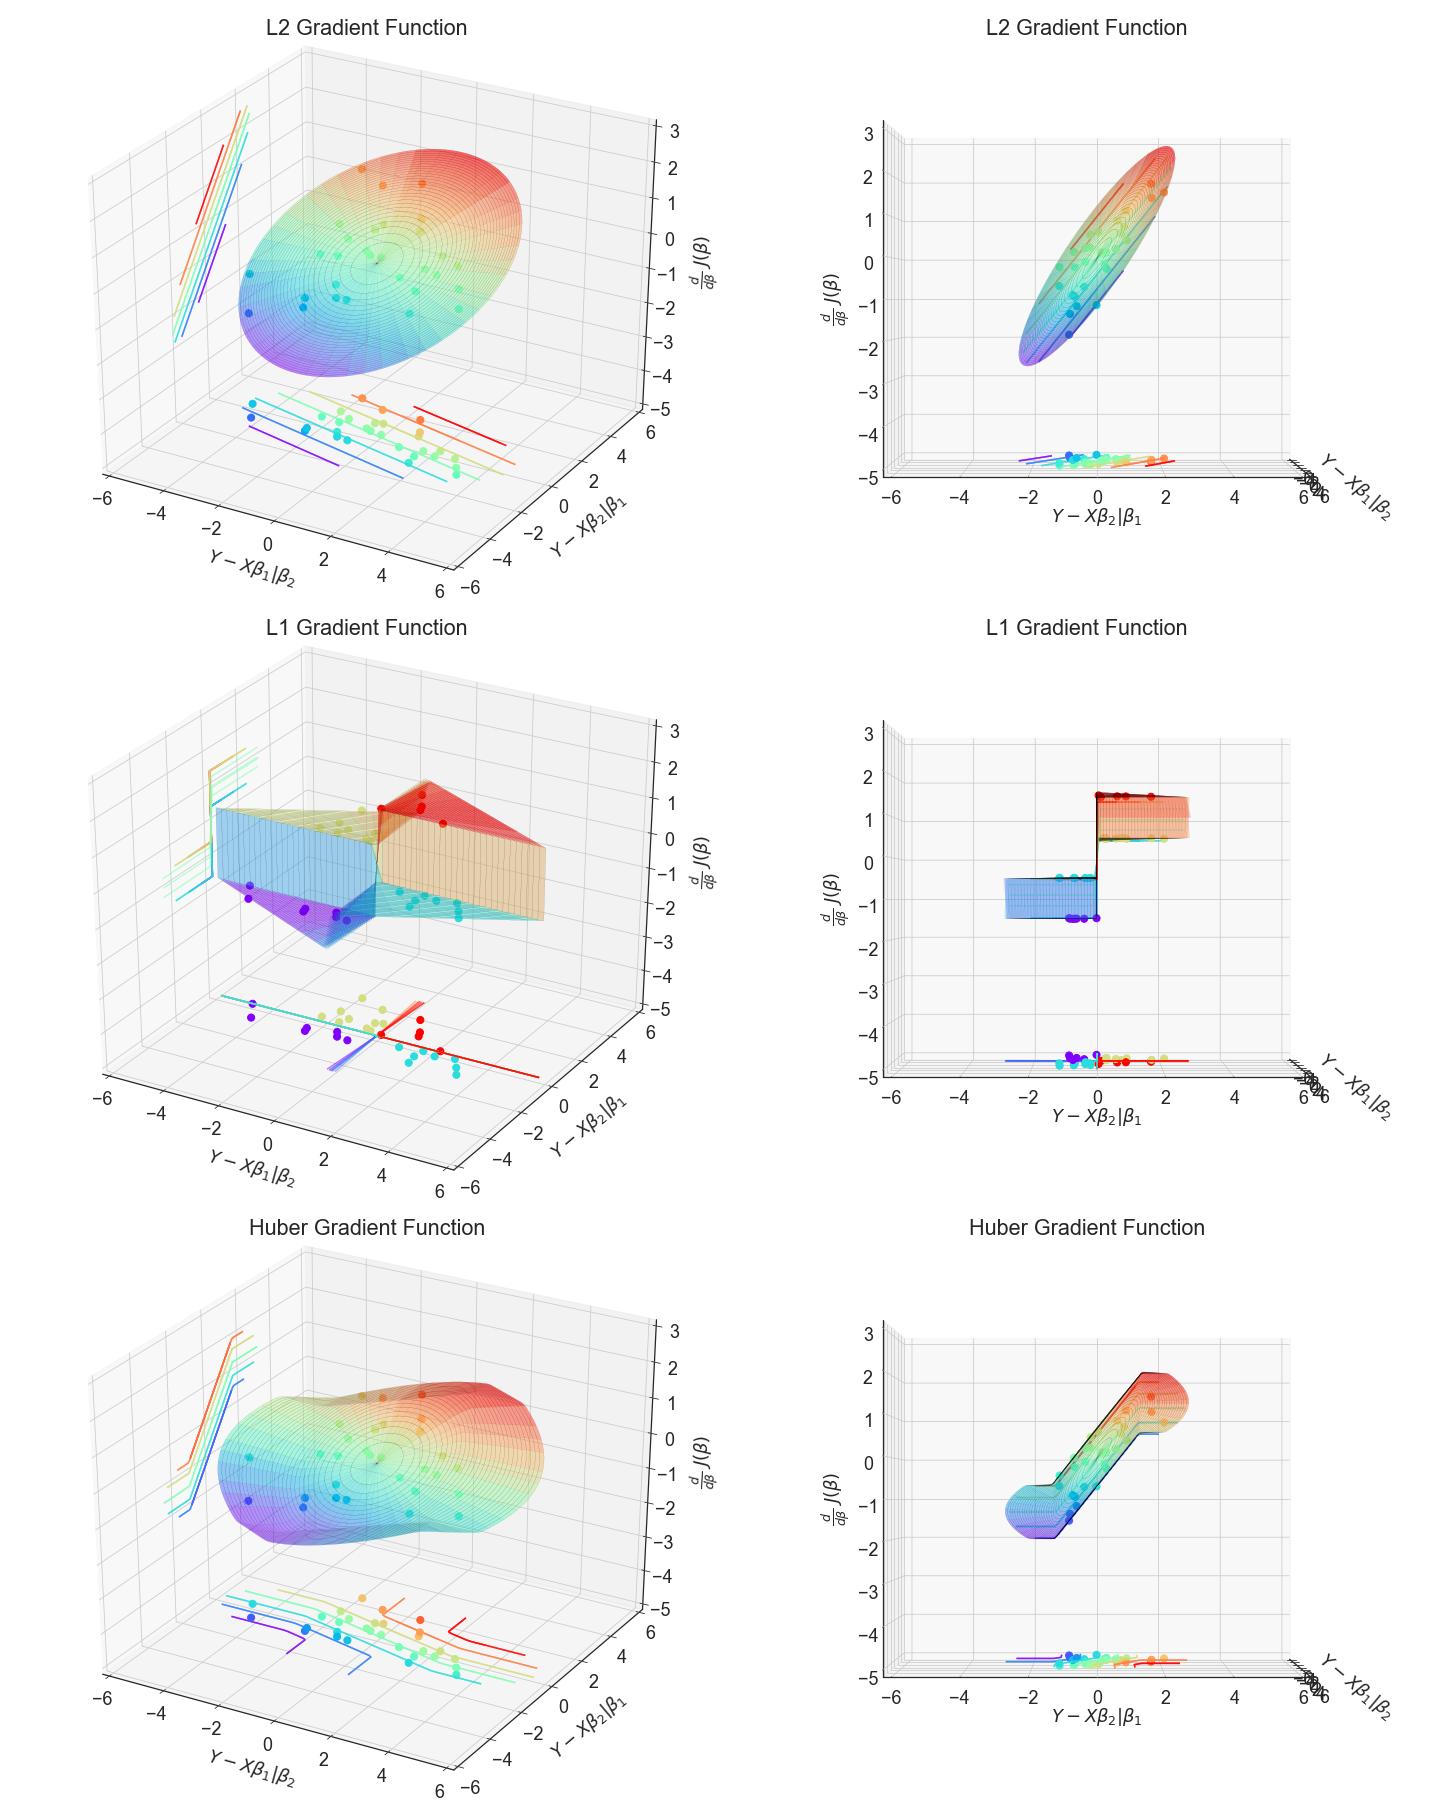

In [23]:
mpl.rcParams['font.size'] = 18
fig = plt.figure(figsize=(20,25))
grad_3D(L2g_2D, 'L2', zmin=-5, zmax=3, row=(3,1))
grad_3D(L1g_2D, 'L1', zmin=-5, zmax=3, row=(3,2))
grad_3D(Huberg_2D, 'Huber', zmin=-5, zmax=3, row=(3,3))

plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0)
plt.show()

The L2 gradient is a flat plane (technially a hyperplane for *n*-dimensional problems). The L1 gradient, when looked on-edge (right plot), shows that as zero is crossed, the gradient changes from -1 to +1. In the other direction, it changes from -0.5 to +0.5 due to elliptical shape we've created. The Huber is a very interesting shape, giving an exact likeness of the L2 at values close to zero, but then reproducing the constant -1 and +1 at the edges like the L1.

## Stochastic Gradient Descent
Finally, we'll implement an SGD algorithm, which lets us define an arbitrary cost function to optimize! With SGD, we can also use non-linear cost functions, as long as we have a function for the gradient. We'll first define the SGD function:

In [24]:
def sgd(X, Y, costfun, gradfun, predfun=None, residfun=None, batches=1, rate=.001, tol=1e-3, max_epoch = 1000, randW=True):
    
    # set up matrices if not already
    X = np.matrix(X.reshape(len(Y),-1))
    Y = np.matrix(Y.reshape(-1,1))
    
    try:
        W_ols = (X.T @ X).I @ (X.T @ Y)
    # initialize weights with OLS estimate
        if randW:
            W = np.matrix((np.random.rand(X.shape[1], 1)) * 2 - 1)
        else:
            W = W_ols
    except:
        W = np.matrix(np.random.rand(X.shape[1], 1) * 2 - 1)
        W_ols = W

    # Define prediction function, default to linear model
    if predfun is None:
        def lm(X=X, W=W):
            return X @ W
        predfun = lm    

    # Define residual function, default to linear model
    if residfun is None:
        def first_diff(X=X, Y=Y, W=W, predfun=predfun):
            Yhat = predfun(X, W)
            return Y - Yhat
        residfun = first_diff    

    # break up a large data set into computationally feasable batches
    def batch(X, Y, batches):
        s = X.shape[0] // batches
        for i in np.arange(0, X.shape[0],s):
            yield (X[i:i+s,:], Y[i:i+s,:])

    # calculate residuals   
    cost = []
    delta_e = []
    e_ols = residfun(X, Y, W_ols)
    cost.append(costfun(residfun(), e_ols))
    delta_e.append(cost[-1])
    
    for epoch in range(max_epoch):
        for (x, y) in batch(X, Y, batches):
            e = residfun(x, y)
            for wj, xj in zip(W, x.T):
                xj = xj.T
                wj -= rate * gradfun(e, xj, e_ols)  

        e = residfun()
        cost.append(costfun(residfun(), e_ols))
        delta_e.append(np.abs(cost[-1] - cost[-2]))
        if delta_e[-1] <= tol:
            break
        
    return W, cost, delta_e

#### Recall the L2 (Least Squares) Cost and Gradient functions:  

$$
\begin{align}
J_{L2}(\beta) & = \sum\limits_{i=1}^n \left( y_i - \beta x_i \right) ^2
  & = (Y - X\beta)'(Y - X\beta) \\[1.2em]
\frac{\partial J_{L2}(\beta)}{\partial \beta} & = -2\sum\limits_{i=1}^n x_i \left( y_i - \beta x_i \right)
  & = -2 X' (Y - X\beta)
\end{align}
$$

Define the Cost and Gradient functions, and use our SGD algorithm to regress.

In [25]:
def L2(e, e_ols=None):
    return np.sum(e.A**2)

def L2g(e, xj, e_ols=None):
    return -2 * np.sum(e.A * xj.A)

In [26]:
# Reset our True regression
X, Y, w = mr(n_samples=20, n_features=1, coef=True, noise=10., bias=1.5, random_state=4)

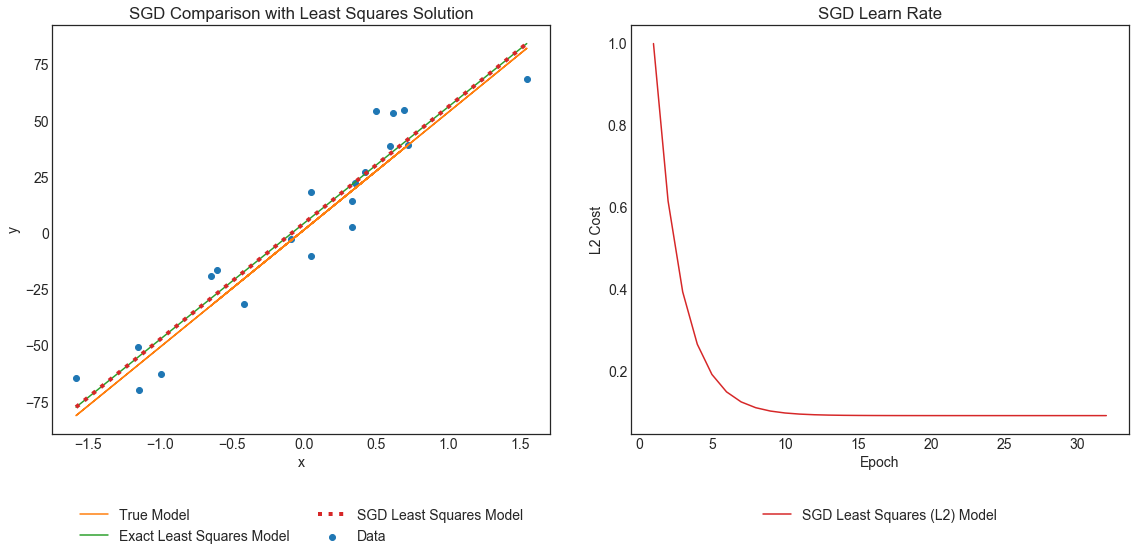

In [27]:
w_L2, cost_L2, delta_e_L2 = sgd(X0, Y0, L2, L2g, batches=1, rate=1e-2, tol=1e-3, max_epoch=80, randW=True)

# Plot our regression
mpl.rcParams['font.size'] = 14
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121)
ax.scatter(X0.A[:,1], Y0.A, c=colors[0], label='Data')
ax.plot(X0[:,1], w*X + 1.5, c=colors[1], label='True Model')
ax.plot(X_test[:,1], X_test @ w0, c=colors[2], ls='-', label='Exact Least Squares Model')
ax.plot(X_test[:,1], X_test @ w_L2, c=colors[3], ls=':', lw=4, label='SGD Least Squares Model')

plt.ylabel('y')
plt.xlabel('x')
plt.title('SGD Comparison with Least Squares Solution')
plt.legend(bbox_to_anchor=(.5, -.15), loc=9, ncol=2)


ax = fig.add_subplot(122)
ax.plot(np.arange(1,len(cost_L2)+1), cost_L2/np.max(cost_L2), c=colors[3], label='SGD Least Squares (L2) Model')

plt.ylabel('L2 Cost')
plt.xlabel('Epoch')
plt.title('SGD Learn Rate')
plt.legend(bbox_to_anchor=(.5, -.15), loc=9, ncol=2)

plt.tight_layout()
plt.show()

#### Recall the L1 (Absolute Difference) Cost and Gradient functions:  

$$
\begin{align}
J_{L1}(\beta) & = \sum\limits_{i=1}^n \lvert y_i - \beta x_i \rvert
  & = 1'\lvert Y - X\beta \rvert \\[1.2em]
\frac{\partial J_{L1}(\beta)}{\partial \beta} & = \sum\limits_{i=1}^n
\begin{cases}
    x_i  & \text{for } y - \beta x_i \gt 0 \\
    -x_i & \text{for } y - \beta x_i \lt 0 \\
    0    & \text{for } y - \beta x_i = 0 \\
\end{cases}
 & = \textit{not a continous function}
\end{align}
$$

Define the Cost and Gradient functions, and use our SGD algorithm to regress.

In [28]:
def L1(e, e_ols=None):
    return np.sum(np.abs(e.A))

def L1g(e, xj, e_ols=None):
    e = e.A
    l1g = -np.copy(xj)
    l1g[e < 0.] = -l1g[e < 0.]
    return np.sum(l1g)

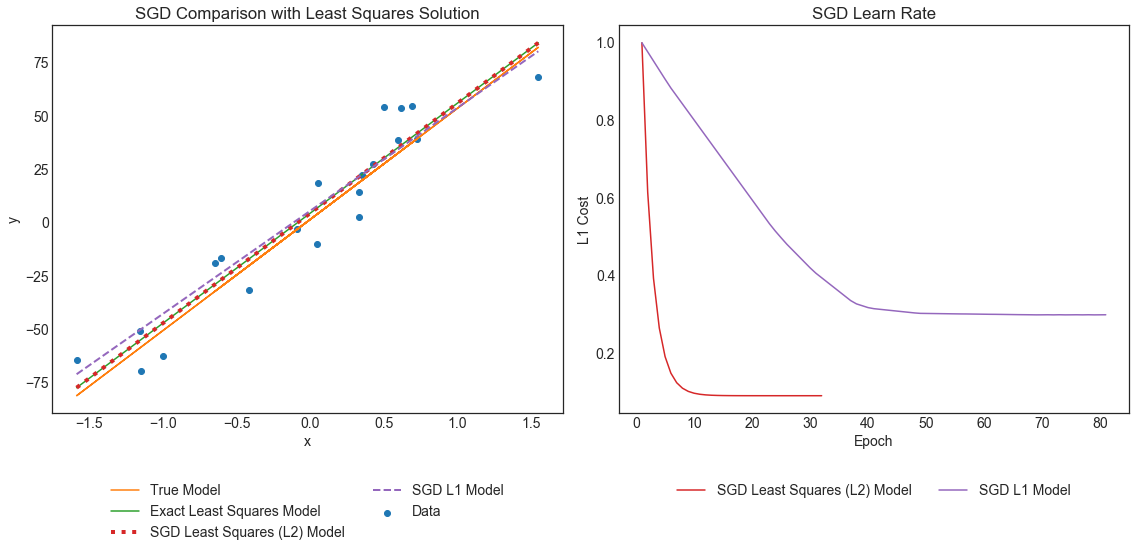

In [29]:
w_L1, cost_L1, delta_e_L1 = sgd(X0, Y0, L1, L1g, batches=1, rate=1e-1, tol=1e-3, max_epoch=80, randW=True)

# Plot our regression
mpl.rcParams['font.size'] = 14
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121)
ax.scatter(X, Y, c=colors[0], label='Data')
ax.plot(X, w*X + 1.5, c=colors[1], label='True Model')
ax.plot(X_test[:,1], X_test @ w0, c=colors[2], ls='-', label='Exact Least Squares Model')
ax.plot(X_test[:,1], X_test @ w_L2, c=colors[3], ls=':', lw=4, label='SGD Least Squares (L2) Model')
ax.plot(X_test[:,1], X_test @ w_L1, c=colors[4], ls='--', lw=2, label='SGD L1 Model')

plt.ylabel('y')
plt.xlabel('x')
plt.title('SGD Comparison with Least Squares Solution')
plt.legend(bbox_to_anchor=(.5, -.15), loc=9, ncol=2)


ax = fig.add_subplot(122)
ax.plot(np.arange(1,len(cost_L2)+1), cost_L2/np.max(cost_L2), c=colors[3], label='SGD Least Squares (L2) Model')
ax.plot(np.arange(1,len(cost_L1)+1), cost_L1/np.max(cost_L1), c=colors[4], label='SGD L1 Model')

plt.ylabel('L1 Cost')
plt.xlabel('Epoch')
plt.title('SGD Learn Rate')
plt.legend(bbox_to_anchor=(.5, -.15), loc=9, ncol=2)

plt.tight_layout()
plt.show()

#### Huber Cost and Gradient functions:

$$
\begin{align}
J_H{\beta} & = \sum\limits_{i=1}^n
\begin{cases}
    \frac{1}{2} \big( y_i - \beta x_i \big)^2          & \text{for } \lvert y - \beta x_i \rvert \leq t \\
    t \, \lvert y - \beta x_i \rvert - \frac{1}{2} t^2 & \text{otherwise}
\end{cases} \\[1.2em]
\frac{\partial J_H(\beta)}{\partial \beta} & = \sum\limits_{i=1}^n
\begin{cases}
    -\big( y_i - \beta x_i \big) x_i & \text{for } \lvert y - \beta x_i \rvert \leq t \\
    t \,  x_i                       & \text{for } y - \beta x_i \gt t \\
    -t \,  x_i                      & \text{for } y - \beta x_i \lt t
\end{cases} \\
\end{align}
$$

Define the Cost and Gradient functions, and use our SGD algorithm to regress.

In [30]:
def Huber(e, e_ols=None, t=1.345):
    e = e.A
    z = np.abs(e)
    huber = np.zeros_like(z)
    huber[z <= t] = 1/2 * z[z <= t]**2
    huber[z > t]  = t * z[z > t] - 1/2 * t**2
    return np.sum(huber)

def Huberg(e, xj, e_ols=None, t=1.345):
    e = e.A
    xj = xj.A
    sign_e = np.sign(e)
    z = np.abs(e)
    huber_g = np.zeros_like(z)
    huber_g[z <= t] = -z[z <= t] * xj[z <= t]
    huber_g[z > t] = -sign_e[z > t] * t * xj[z > t]
    return np.sum(huber_g)

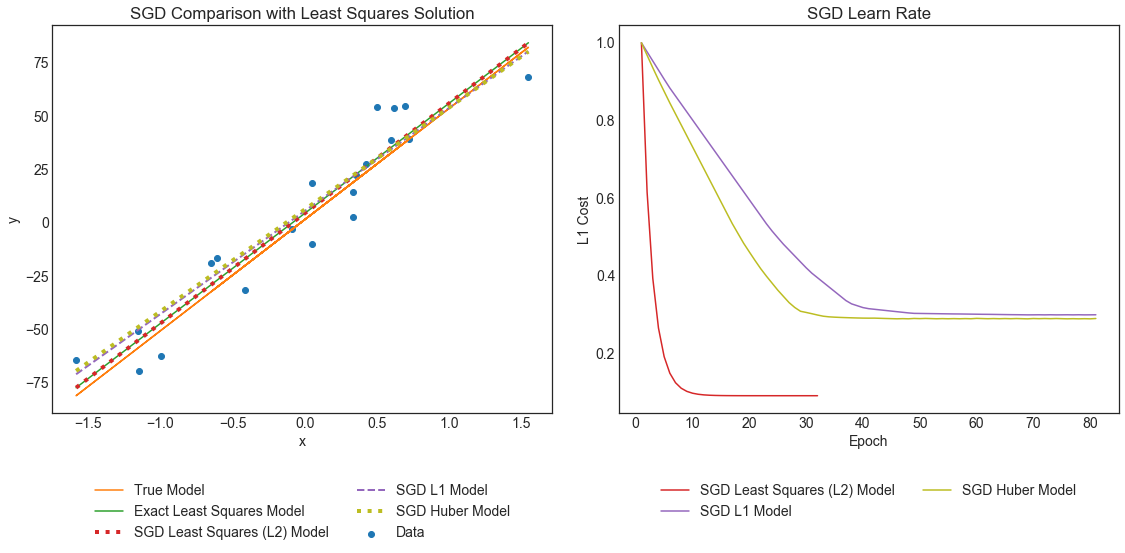

In [31]:
w_H, cost_H, delta_e_H = sgd(X0, Y0, Huber, Huberg, batches=1, rate=1e-1, tol=1e-3, max_epoch=80, randW=True)

# Plot our regression
mpl.rcParams['font.size'] = 14
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121)
ax.scatter(X, Y, c=colors[0], label='Data')
ax.plot(X, w*X + 1.5, c=colors[1], label='True Model')
ax.plot(X_test[:,1], X_test @ w0, c=colors[2], ls='-', label='Exact Least Squares Model')
ax.plot(X_test[:,1], X_test @ w_L2, c=colors[3], ls=':', lw=4, label='SGD Least Squares (L2) Model')
ax.plot(X_test[:,1], X_test @ w_L1, c=colors[4], ls='--', lw=2, label='SGD L1 Model')
ax.plot(X_test[:,1], X_test @ w_H, c=colors[8], ls=':', lw=4, label='SGD Huber Model')

plt.ylabel('y')
plt.xlabel('x')
plt.title('SGD Comparison with Least Squares Solution')
plt.legend(bbox_to_anchor=(.5, -.15), loc=9, ncol=2)


ax = fig.add_subplot(122)
ax.plot(np.arange(1,len(cost_L2)+1), cost_L2/np.max(cost_L2), c=colors[3], label='SGD Least Squares (L2) Model')
ax.plot(np.arange(1,len(cost_L1)+1), cost_L1/np.max(cost_L1), c=colors[4], label='SGD L1 Model')
ax.plot(np.arange(1,len(cost_H)+1), cost_H/np.max(cost_H), c=colors[8], label='SGD Huber Model')

plt.ylabel('L1 Cost')
plt.xlabel('Epoch')
plt.title('SGD Learn Rate')
plt.legend(bbox_to_anchor=(.5, -.15), loc=9, ncol=2)

plt.tight_layout()
plt.show()

#### Comparison of L2, L1, and Huber
These models are all pretty similar, to the point where there is no preference for one or the other(s). The variance of the residuals is much greater than the slight difference of the models. Although these models may have *statistical* differences, their *predictions* are practically the same.

However, let's see what happens we we bring back the error on our single datapoint.

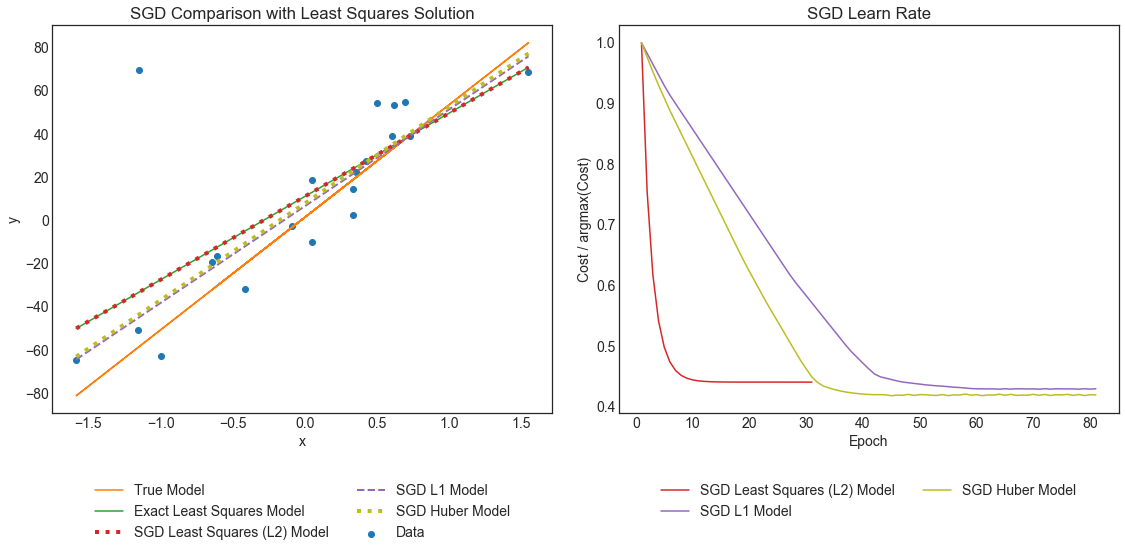

In [32]:
w_L2, cost_L2, delta_e_L2 = sgd(X0, Y0_err, L2, L2g, batches=1, rate=1e-2, tol=1e-3, max_epoch=80, randW=True)
w_L1, cost_L1, delta_e_L1 = sgd(X0, Y0_err, L1, L1g, batches=1, rate=1e-1, tol=1e-3, max_epoch=80, randW=True)
w_H, cost_H, delta_e_H = sgd(X0, Y0_err, Huber, Huberg, batches=1, rate=1e-1, tol=1e-3, max_epoch=80, randW=True)

# Plot our regression
mpl.rcParams['font.size'] = 14
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121)
ax.scatter(X, Y0_err.A, c=colors[0], label='Data')
ax.plot(X, w*X + 1.5, c=colors[1], label='True Model')
ax.plot(X_test[:,1], X_test @ w0_err, c=colors[2], ls='-', label='Exact Least Squares Model')
ax.plot(X_test[:,1], X_test @ w_L2, c=colors[3], ls=':', lw=4, label='SGD Least Squares (L2) Model')
ax.plot(X_test[:,1], X_test @ w_L1, c=colors[4], ls='--', lw=2, label='SGD L1 Model')
ax.plot(X_test[:,1], X_test @ w_H, c=colors[8], ls=':', lw=4, label='SGD Huber Model')

plt.ylabel('y')
plt.xlabel('x')
plt.title('SGD Comparison with Least Squares Solution')
plt.legend(bbox_to_anchor=(.5, -.15), loc=9, ncol=2)


ax = fig.add_subplot(122)
ax.plot(np.arange(1,len(cost_L2)+1), cost_L2/np.max(cost_L2), c=colors[3], label='SGD Least Squares (L2) Model')
ax.plot(np.arange(1,len(cost_L1)+1), cost_L1/np.max(cost_L1), c=colors[4], label='SGD L1 Model')
ax.plot(np.arange(1,len(cost_H)+1), cost_H/np.max(cost_H), c=colors[8], label='SGD Huber Model')

plt.ylabel('Cost / argmax(Cost)')
plt.xlabel('Epoch')
plt.title('SGD Learn Rate')
plt.legend(bbox_to_anchor=(.5, -.15), loc=9, ncol=2)

plt.tight_layout()
plt.show()

#### Comparison of L2, L1, and Huber with outlier
Suddenly, we see that the L1 and Huber cost functions are only mildly affect by the outlier &mdash; much less so than the L2 (least squares) cost function. We say that the L1 and L2 are much more ***robust***, i.e. stable in the presence of outliers. This provides significant advantages for processing large amounts of data where it may be unfeasible to visualize every feature and filter every outlier.

It's worth pointing out that robust regression applies to non-linear regression as well, because we're only changing the metric used to judge goodness of fit! We'll discuss optimization of arbritary non-linear functions in a later post.